In [36]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge
import scipy.stats as stats

current_dir = os.getcwd()

data_paths = {
    "energies": os.path.join(current_dir, "../data", "energies.npy"),
    "2-body": os.path.join(current_dir, "../data", "features_2b.npy"),
    "3-body": os.path.join(current_dir, "../data", "features_3b.npy"),
    "4-body": os.path.join(current_dir, "../data", "features_4b.npy"),
}

In [6]:


def load_data_standardized(feature_choice):
    """
    Dynamically load data based on the feature choice.
    Options:
    - "2-body": Use 2-body features only
    - "3-body": Use 3-body features only
    - "4-body": Use 4-body features only
    - "2+3-body": Combine 2-body and 3-body features
    - "3+4-body": Combine 3-body and 4-body features
    - "2+3+4-body": Combine all features
    """
    energies = np.load(data_paths["energies"])

    if feature_choice == "2-body":
        features = np.load(data_paths["2-body"])
        features = (features - features.mean())/features.std()
    elif feature_choice == "3-body":
        features = np.load(data_paths["3-body"])
        features = (features - features.mean())/features.std()
    elif feature_choice == "4-body":
        features = np.load(data_paths["4-body"])
        features = (features - features.mean())/features.std()
    elif feature_choice == "2+3-body":
        features_2 = np.load(data_paths["2-body"])
        features_2 =(features_2 - features_2.mean())/features_2.std()
        features_3 = np.load(data_paths["3-body"])
        features_3 = (features_3 - features_3.mean())/features_3.std()
        features = np.hstack((features_2, features_3))
    elif feature_choice == "4+3-body":
        features_4 = np.load(data_paths["4-body"])
        features_4 = (features_4 - features_4.mean())/features_4.std()
        features_3 = np.load(data_paths["3-body"])
        features_3 = (features_3 - features_3.mean())/features_3.std()
        features = np.hstack((features_4, features_3))
    elif feature_choice == "2+3+4-body":
        features_2 = np.load(data_paths["2-body"])
        features_2 = (features_2 - features_2.mean())/features_2.std()
        features_3 = np.load(data_paths["3-body"])
        features_3 = (features_3 - features_3.mean())/features_3.std()
        features_4 = np.load(data_paths["4-body"])
        features_4 = (features_4 - features_4.mean())/features_4.std()
        features = np.hstack((features_2, features_3, features_4))
    else:
        raise ValueError("Invalid feature choice!")

    energies = (energies - energies.mean())/energies.std()
    
    return features, energies


# Learning curve functions
def plot_learning_curve_with_test(model, X_train, X_test, y_train, y_test, title="Learning Curve"):
    train_sizes = np.logspace(np.log10(0.1), np.log10(1.0), 10)
    train_errors = []
    test_errors = []

    for train_size in train_sizes:
        train_subset_size = int(train_size * len(X_train))
        X_train_subset = X_train[:train_subset_size]
        y_train_subset = y_train[:train_subset_size]

        model.fit(X_train_subset, y_train_subset)

        train_rmse = np.sqrt(np.mean((model.predict(X_train_subset) - y_train_subset) ** 2))
        train_errors.append(train_rmse)

        test_rmse = np.sqrt(np.mean((model.predict(X_test) - y_test) ** 2))
        test_errors.append(test_rmse)

    # Plot
    plt.figure()
    plt.title(title)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Training examples")
    plt.ylabel("Root Mean Squared Error")
    plt.grid()

    plt.plot(train_sizes * len(X_train), train_errors, 'o-', color="r", label="Training error")
    plt.plot(train_sizes * len(X_train), test_errors, 'o-', color="g", label="Test error")

    plt.legend(loc="best")
    plt.show()


def plot_learning_curve_kfold(model, X, y, n_splits=5, title="Learning Curve with K-Fold CV"):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_sizes = np.logspace(np.log10(0.1), np.log10(1.0), 10)

    all_train_errors = []
    all_test_errors = []

    for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        train_errors = []
        test_errors = []

        for train_size in train_sizes:
            train_subset_size = int(train_size * len(X_train))
            X_train_subset = X_train[:train_subset_size]
            y_train_subset = y_train[:train_subset_size]

            model.fit(X_train_subset, y_train_subset)

            train_rmse = np.sqrt(np.mean((model.predict(X_train_subset) - y_train_subset) ** 2))
            test_rmse = np.sqrt(np.mean((model.predict(X_test) - y_test) ** 2))

            train_errors.append(train_rmse)
            test_errors.append(test_rmse)

        all_train_errors.append(train_errors)
        all_test_errors.append(test_errors)

        plt.plot(train_sizes * len(X_train), train_errors, 'o--', label=f"Fold {fold_idx + 1} Training", alpha=0.4, color="r")
        plt.plot(train_sizes * len(X_train), test_errors, 'o--', label=f"Fold {fold_idx + 1} Test", alpha=0.4, color="g")

    plt.xscale("log")
    plt.yscale("log")
    plt.title(f"{title} - Individual Folds")
    plt.xlabel("Training examples")
    plt.ylabel("Root Mean Squared Error")
    plt.grid()
    plt.legend(loc="best", ncol=2, fontsize="small")
    plt.show()

    all_train_errors = np.array(all_train_errors)
    all_test_errors = np.array(all_test_errors)

    train_errors_mean = all_train_errors.mean(axis=0)
    train_errors_std = all_train_errors.std(axis=0)
    test_errors_mean = all_test_errors.mean(axis=0)
    test_errors_std = all_test_errors.std(axis=0)

    plt.figure()
    plt.title(f"{title} - Mean with Error Bars")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Training examples")
    plt.ylabel("Root Mean Squared Error")
    plt.grid()

    plt.fill_between(train_sizes * len(X_train), train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1, color="r")
    plt.plot(train_sizes * len(X_train), train_errors_mean, 'o-', color="r", label="Average Training error")

    plt.fill_between(train_sizes * len(X_train), test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes * len(X_train), test_errors_mean, 'o-', color="g", label="Average Test error")

    plt.legend(loc="best")
    plt.show()






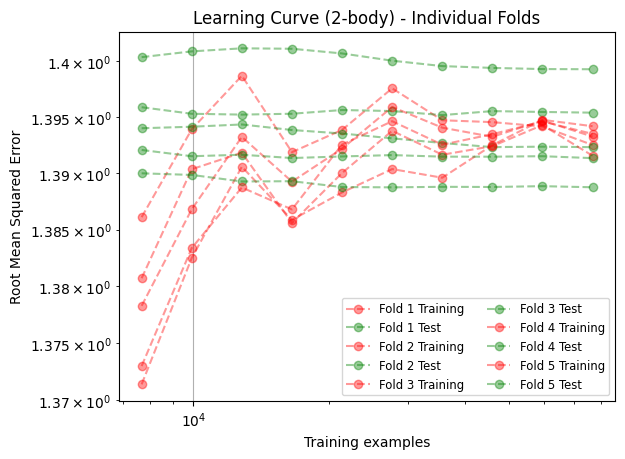

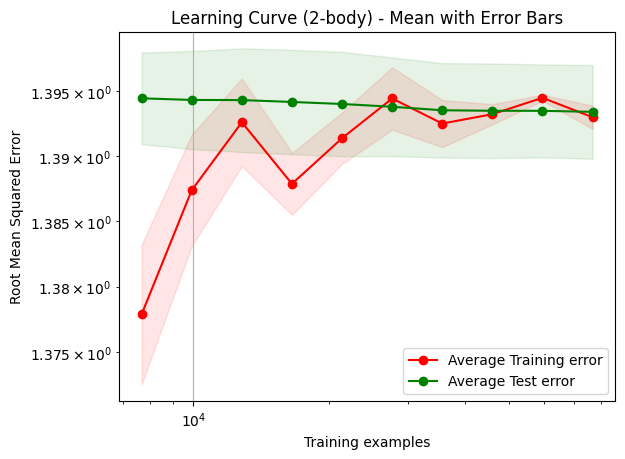

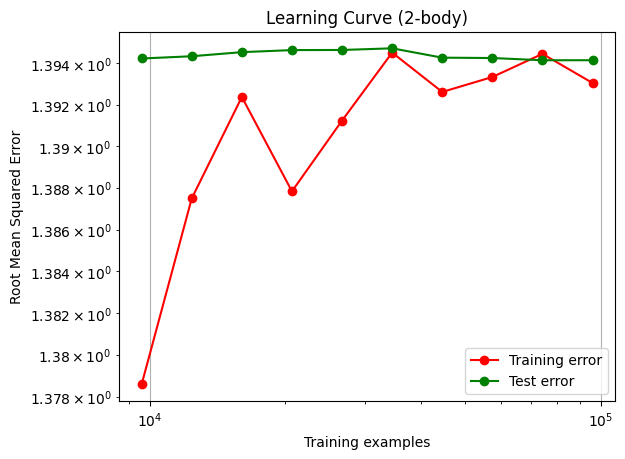

In [ ]:
feature_choice = "2-body"  # Options: "2-body", "3-body", "4-body", "2+3-body", "2+3+4-body"
X,y = load_data_standardized(feature_choice)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plot_learning_curve_kfold(LinearRegression(), X_train, y_train, title=f"Learning Curve ({feature_choice})")
plot_learning_curve_with_test(LinearRegression(), X_train, X_test, y_train, y_test, title=f"Learning Curve ({feature_choice})")


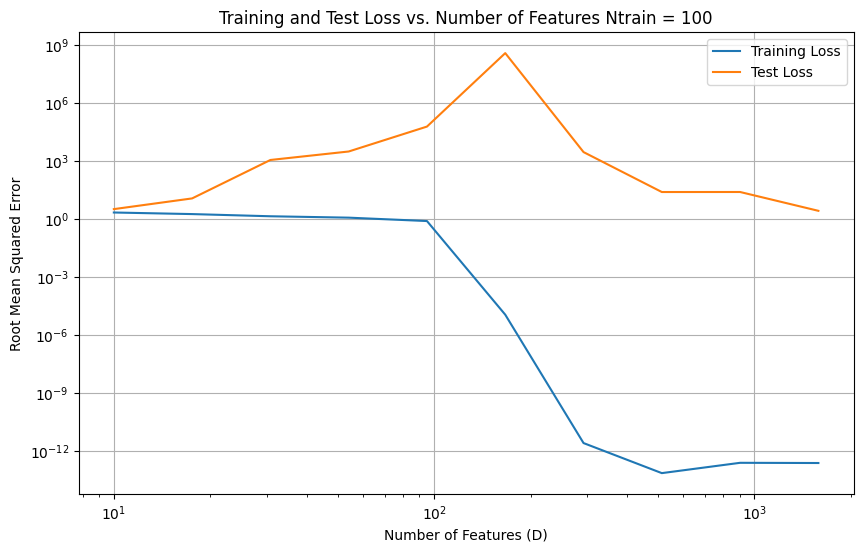

In [ ]:

X, y = load_data_standardized("3-body")

Ntrain = 100
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=Ntrain, random_state=42)


train_loss = []
test_loss = []
D_values = np.logspace(np.log10(10), np.log10(1584), 10)


for D in D_values:
    D = int(D)
    model = LinearRegression()
    model.fit(X_train[:, :D], y_train)

    y_train_pred = model.predict(X_train[:, :D])
    train_rmse = np.sqrt(np.mean((y_train_pred - y_train) ** 2))
    train_loss.append(train_rmse)

    y_test_pred = model.predict(X_test[:, :D])
    test_rmse = np.sqrt(np.mean((y_test_pred - y_test) ** 2))
    test_loss.append(test_rmse)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(D_values, train_loss, label="Training Loss")
plt.plot(D_values, test_loss, label="Test Loss")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Features (D)")
plt.ylabel("Root Mean Squared Error")
plt.title(f"Training and Test Loss vs. Number of Features Ntrain = {Ntrain}")
plt.legend()
plt.grid(True)
plt.show()

## Lambda searching with Ntrain chosen

In [ ]:
X, y = load_data_standardized("3-body")


Ntrain = 1600
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=Ntrain, random_state=42)

lambda_values = np.logspace(-20, 20, 100)

train_errors = []
test_errors = []

for l in lambda_values:

    ridge = Ridge(alpha=l)
    ridge.fit(X_train, y_train)

    y_train_pred = ridge.predict(X_train)
    train_rmse = np.sqrt(np.mean((y_train_pred - y_train) ** 2))

    y_test_pred = ridge.predict(X_test)
    test_rmse = np.sqrt(np.mean((y_test_pred - y_test) ** 2))

    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

plt.figure(figsize=(10, 6))
plt.plot(lambda_values, train_errors, label="Training Error")
plt.plot(lambda_values, test_errors, label="Test Error")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Regularization Parameter (λ)")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title(f"Training and Test Error vs. Regularization Parameter λ Ntrain={Ntrain}")
plt.legend(loc="best")
plt.grid(True)

plt.show()


## Lambda search with kfold


In [ ]:
X, y = load_data_standardized("3-body")


lambda_values = np.logspace(-20, 20, 100)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_errors = np.zeros((kf.get_n_splits(), len(lambda_values)))
test_errors = np.zeros((kf.get_n_splits(), len(lambda_values)))

for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for i, l in enumerate(lambda_values):

        ridge = Ridge(alpha=l)
        ridge.fit(X_train, y_train)  
        
        y_train_pred = ridge.predict(X_train)
        train_rmse = np.sqrt(np.mean((y_train_pred - y_train) ** 2))

        y_test_pred = ridge.predict(X_test)
        test_rmse = np.sqrt(np.mean((y_test_pred - y_test) ** 2))
        
        train_errors[fold_idx, i] = train_rmse
        test_errors[fold_idx, i] = test_rmse

plt.figure(figsize=(10, 6))

for fold_idx in range(kf.get_n_splits()):
    plt.plot(lambda_values, train_errors[fold_idx], label=f"Training Error - Fold {fold_idx+1}", linestyle="--", alpha=0.5)
    plt.plot(lambda_values, test_errors[fold_idx], label=f"Test Error - Fold {fold_idx+1}", linestyle="-", alpha=0.5)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Regularization Parameter (λ)")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title(f"Training and Test Error vs. Regularization Parameter λ (with K-Fold Cross-Validation) Ntrain=")

plt.legend(loc="best", ncol=2, fontsize="small")
plt.grid(True)

plt.show()

c:\Users\valbi\ML_env\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.72099e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\valbi\ML_env\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.26791e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\valbi\ML_env\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.80912e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\valbi\ML_env\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.92873e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\valbi\ML_env\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarnin

# Body-Ordered Decomposition of Energy

Train the model using only the two body -> get energy  
Energy for which structure??
For each value in the test set using the model trained on the 2b -> get energy value
For each value in the test set using the model trained on the 2+3 -> get the energy values for the train set where the features are only the two body features
For each value in the test set using the model trained on the 2+3+4 -> get the energy values for the train set where the features are only the two body features
For each value in the test set using the model trained on the 2+3 -> get the energy values for the train set where the features are only the three body features
For each value in the test set using the model trained on the 2+3+4 -> get the energy values for the train set where the features are only the three body features

Question:
What energies ? The test set will contain many molecules-> for each molecule I can get a value and store these values in an array
Can compute a mean energy, median, quartiles, std and such 
Can compute energy differences 

Question:
How do I import the features in the cell in such a way that I can split the 2 and 3 body when testing but combine them in the prediction
Not ideal but just split by taking the first 100000 to train and the remaining 20000 for the test


In [31]:
lambda_2 = 0.3199
lambda_23 = 7.743
lambda_234 = 0.02154

In [22]:
#Get energy, train on 2b, test using 2b

X, y = load_data_standardized("2-body")

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100000, random_state=42)

X_train_2 = X[:100000]
y_train_2 = y[:100000]
X_test_2 = X[100000:]
y_test_2 = y[100000:]


ridge = Ridge(alpha=lambda_2)
ridge.fit(X_train_2, y_train_2)  
y_test_pred_tr2_te2 = ridge.predict(X_test_2)


In [54]:
#Get energy, train on 3b, test using 3b

X, y = load_data_standardized("3-body")


X_train_3 = X[:100000]
y_train_3 = y[:100000]
X_test_3 = X[100000:]
y_test_3 = y[100000:]


ridge = Ridge(alpha=lambda_23)
ridge.fit(X_train_3, y_train_3)  
y_test_pred_tr3_te3 = ridge.predict(X_test_3)

In [27]:
# Get energy, train on 2+3 test on 2+3 and 2

X, y = load_data_standardized("2+3-body")

X_train_23 = X[:100000]
y_train_23 = y[:100000]
X_test_23 = X[100000:]
y_test_23 = y[100000:]


ridge = Ridge(alpha=lambda_23)
ridge.fit(X_train_23, y_train_23)
y_test_pred_tr23_te23 = ridge.predict(X_test_23)

# y_test_pred_tr23_te2 = ridge.predict(X_test_2)

X_test_2_new = np.zeros((20000, 1600))
X_test_2_new[:, :16] = X_test_2
y_test_pred_tr23_te2 = ridge.predict(X_test_2_new)


zero_array = np.zeros((20000, 16))
print(X_test_23.shape)
X_test_3 = X_test_23.copy()
X_test_3[:,:16] = zero_array
y_test_pred_tr23_te3 = ridge.predict(X_test_3)


diff = y_test_pred_tr2_te2 - y_test_pred_tr23_te2

print(diff)


(20000, 1600)
[-0.35300769 -0.35413798 -0.09033555 ... -0.14160314 -0.31832746
 -0.20140103]


In [35]:
# Get energy, train on 2+3+4
X, y = load_data_standardized("2+3+4-body")

X_train_234 = X[:100000]
y_train_234 = y[:100000]
X_test_234 = X[100000:]
y_test_234 = y[100000:]

# print(X_test_234.shape) # 4 body has total of 3600 features


ridge = Ridge(alpha=lambda_234)
ridge.fit(X_train_234, y_train_234)
y_test_pred_tr234_te234 = ridge.predict(X_test_234)

X_test_2_new = np.zeros((20000, 3600))
X_test_2_new[:, :16] = X_test_2
y_test_pred_tr234_te2 = ridge.predict(X_test_2_new)

zero_array = np.zeros((20000, 16))
X_test_3 = X_test_234.copy()
X_test_3[:,:16] = zero_array
zero_array = np.zeros((20000, 2000))
X_test_3[:,1600:] = zero_array
y_test_pred_tr234_te3 = ridge.predict(X_test_3)

train with 2 body, energy from 2 bodyDescribeResult(nobs=20000, minmax=(-2.7757186765051465, 13.100301701503515), mean=0.0035285211443544773, variance=0.8485311007625721, skewness=3.421717187313511, kurtosis=21.935311327306483)
train with 2+3 body, energy from 2 bodyDescribeResult(nobs=20000, minmax=(-2.831385930601026, 1.341790050768392), mean=0.1649480455510253, variance=0.3702216525419527, skewness=-0.6135517835045029, kurtosis=0.12396057140712857)
train with 2+3+4 body, energy from 2 bodyDescribeResult(nobs=20000, minmax=(-5.701238878947577, 2.2649878786326956), mean=0.3506312965102605, variance=1.1425119842628413, skewness=-0.8724923677112908, kurtosis=0.6513409173948106)
actual energy DescribeResult(nobs=20000, minmax=(-2.929646128896188, 12.747283130003368), mean=-0.00013950106833275768, variance=1.0255547422093227, skewness=2.5221623289804525, kurtosis=14.14380645146084)


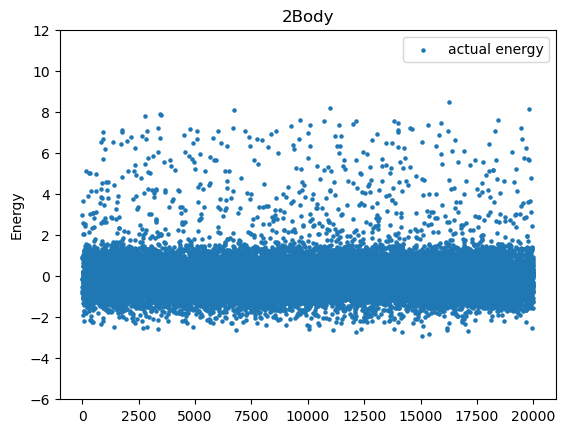

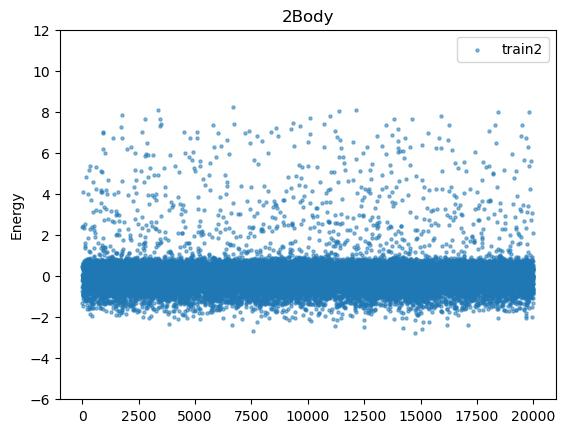

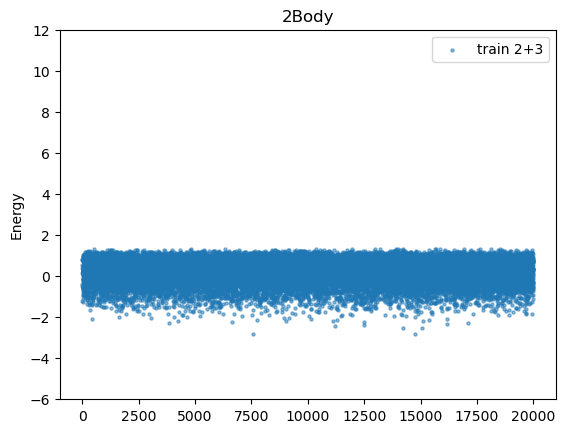

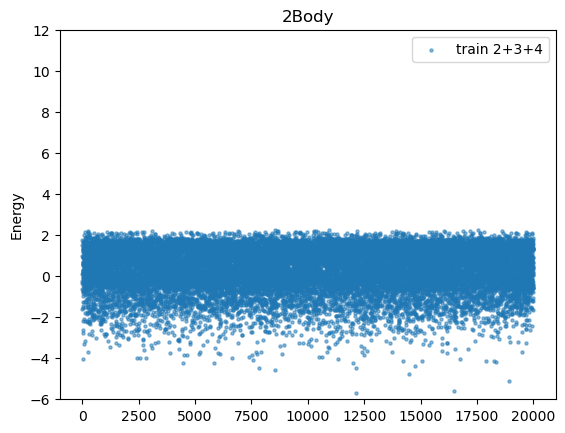

In [57]:
y_test_pred_tr2_te2 
y_test_pred_tr23_te2
y_test_pred_tr234_te2
y_test_234

print(f"train with 2 body, energy from 2 body{stats.describe(y_test_pred_tr2_te2)}")
print(f"train with 2+3 body, energy from 2 body{stats.describe(y_test_pred_tr23_te2)}")
print(f"train with 2+3+4 body, energy from 2 body{stats.describe(y_test_pred_tr234_te2)}")
print(f"actual energy {stats.describe(y_test_234)}")

points_values = np.arange(0,20000,1)
# plt.scatter(points_values, y_test_pred_tr2_te2, s=5, label = "train2", alpha=0.5)
# plt.scatter(points_values, y_test_pred_tr23_te2, s=5, label="train 2+3", alpha=0.5)
# plt.scatter(points_values, y_test_pred_tr234_te2, s=5, label= "train 2+3+4", alpha=0.5)
plt.scatter(points_values, y_test_234, s=5, label = "actual energy")
plt.title("2Body")
plt.ylim(-6,12)
plt.legend()
plt.ylabel("Energy")
plt.show()

points_values = np.arange(0,20000,1)
plt.scatter(points_values, y_test_pred_tr2_te2, s=5, label = "train2", alpha=0.5)
# plt.scatter(points_values, y_test_pred_tr23_te2, s=5, label="train 2+3", alpha=0.5)
# plt.scatter(points_values, y_test_pred_tr234_te2, s=5, label= "train 2+3+4", alpha=0.5)
# plt.scatter(points_values, y_test_234, s=5, label = "actual energy")
plt.title("2Body")
plt.ylim(-6,12)
plt.legend()
plt.ylabel("Energy")
plt.show()

points_values = np.arange(0,20000,1)
# plt.scatter(points_values, y_test_pred_tr2_te2, s=5, label = "train2", alpha=0.5)
plt.scatter(points_values, y_test_pred_tr23_te2, s=5, label="train 2+3", alpha=0.5)
# plt.scatter(points_values, y_test_pred_tr234_te2, s=5, label= "train 2+3+4", alpha=0.5)
# plt.scatter(points_values, y_test_234, s=5, label = "actual energy")
plt.title("2Body")
plt.ylim(-6,12)
plt.legend()
plt.ylabel("Energy")
plt.show()

points_values = np.arange(0,20000,1)
# plt.scatter(points_values, y_test_pred_tr2_te2, s=5, label = "train2", alpha=0.5)
# plt.scatter(points_values, y_test_pred_tr23_te2, s=5, label="train 2+3", alpha=0.5)
plt.scatter(points_values, y_test_pred_tr234_te2, s=5, label= "train 2+3+4", alpha=0.5)
# plt.scatter(points_values, y_test_234, s=5, label = "actual energy")
plt.title("2Body")
plt.ylim(-6,12)
plt.legend()
plt.ylabel("Energy")
plt.show()

train with 2 body, energy from 2 bodyDescribeResult(nobs=20000, minmax=(-2.7757186765051465, 13.100301701503515), mean=0.0035285211443544773, variance=0.8485311007625721, skewness=3.421717187313511, kurtosis=21.935311327306483)
train with 2+3 body, energy from 2 bodyDescribeResult(nobs=20000, minmax=(-2.831385930601026, 1.341790050768392), mean=0.1649480455510253, variance=0.3702216525419527, skewness=-0.6135517835045029, kurtosis=0.12396057140712857)
train with 2+3+4 body, energy from 2 bodyDescribeResult(nobs=20000, minmax=(-5.701238878947577, 2.2649878786326956), mean=0.3506312965102605, variance=1.1425119842628413, skewness=-0.8724923677112908, kurtosis=0.6513409173948106)
actual energy DescribeResult(nobs=20000, minmax=(-2.929646128896188, 12.747283130003368), mean=-0.00013950106833275768, variance=1.0255547422093227, skewness=2.5221623289804525, kurtosis=14.14380645146084)


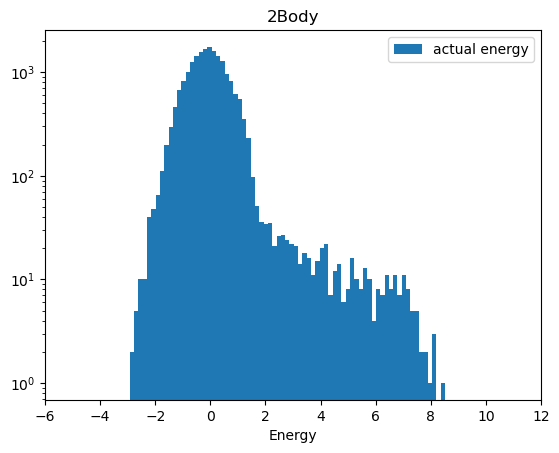

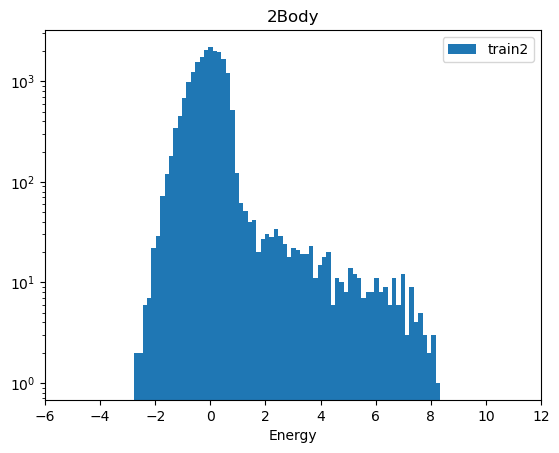

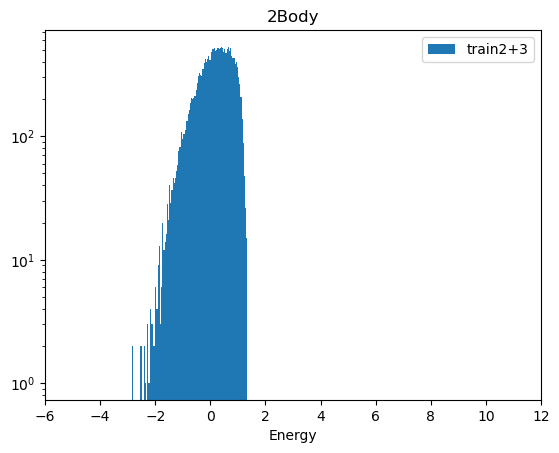

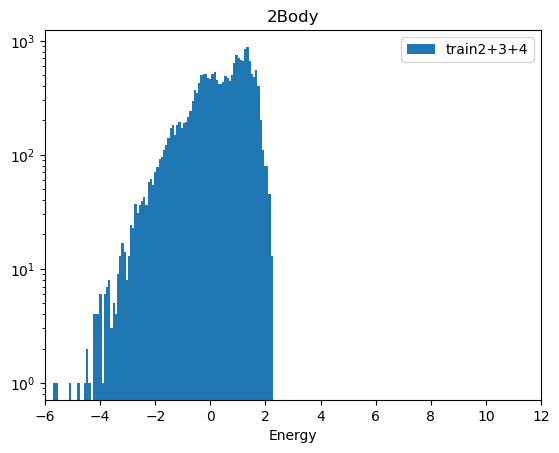

In [73]:
y_test_pred_tr2_te2 
y_test_pred_tr23_te2
y_test_pred_tr234_te2
y_test_234

print(f"train with 2 body, energy from 2 body{stats.describe(y_test_pred_tr2_te2)}")
print(f"train with 2+3 body, energy from 2 body{stats.describe(y_test_pred_tr23_te2)}")
print(f"train with 2+3+4 body, energy from 2 body{stats.describe(y_test_pred_tr234_te2)}")
print(f"actual energy {stats.describe(y_test_234)}")

# plt.hist( y_test_pred_tr2_te2, bins=100, density=True, label = "train2")
# plt.hist( y_test_pred_tr23_te2, bins=100, density=True, label = "train2+3")
# plt.hist( y_test_pred_tr234_te2, bins=100, density=True, label = "train2+3+4")
plt.hist( y_test_234, bins=100, label = "actual energy")
plt.xlim(-6,12)
plt.yscale("log")
plt.title("2Body")
plt.legend()
plt.xlabel("Energy")
plt.show()

plt.hist( y_test_pred_tr2_te2, bins=100, label = "train2")
# plt.hist( y_test_pred_tr23_te2, bins=100, density=True, label = "train2+3")
# plt.hist( y_test_pred_tr234_te2, bins=100, density=True, label = "train2+3+4")
# plt.hist( y_test_234, bins=100, density=True, label = "actual energy")
plt.yscale("log")
plt.xlim(-6,12)
plt.title("2Body")
plt.legend()
plt.xlabel("Energy")
plt.show()

# plt.hist( y_test_pred_tr2_te2, bins=100, density=True, label = "train2")
plt.hist( y_test_pred_tr23_te2, bins=100, label = "train2+3")
# plt.hist( y_test_pred_tr234_te2, bins=100, density=True, label = "train2+3+4")
# plt.hist( y_test_234, bins=100, density=True, label = "actual energy")
plt.yscale("log")
plt.xlim(-6,12)
plt.title("2Body")
plt.legend()
plt.xlabel("Energy")
plt.show()

# plt.hist( y_test_pred_tr2_te2, bins=100, density=True, label = "train2")
# plt.hist( y_test_pred_tr23_te2, bins=100, density=True, label = "train2+3")
plt.hist( y_test_pred_tr234_te2, bins=100, label = "train2+3+4")
# plt.hist( y_test_234, bins=100, density=True, label = "actual energy")
plt.yscale("log")
plt.xlim(-6,12)
plt.title("2Body")
plt.legend()
plt.xlabel("Energy")
plt.show()

train with 3 body, energy from 3 bodyDescribeResult(nobs=20000, minmax=(-3.176969863347898, 12.594378591591214), mean=0.0019705625541382907, variance=0.9951875976396704, skewness=2.6430665068395696, kurtosis=14.940040964654635)
train with 2+3 body, energy from 3 bodyDescribeResult(nobs=20000, minmax=(-3.125971568031379, 12.298544463785445), mean=0.038472594074428455, variance=0.7253101825088327, skewness=4.346243853413304, kurtosis=29.195280976792)
train with 2+3+4 body, energy from 3 bodyDescribeResult(nobs=20000, minmax=(-3.637372137937631, 12.991677635281361), mean=0.022751584155924067, variance=1.2678633657082974, skewness=2.9864089166591645, kurtosis=14.528779216186251)
actual energy DescribeResult(nobs=20000, minmax=(-2.929646128896188, 12.747283130003368), mean=-0.00013950106833275768, variance=1.0255547422093227, skewness=2.5221623289804525, kurtosis=14.14380645146084)


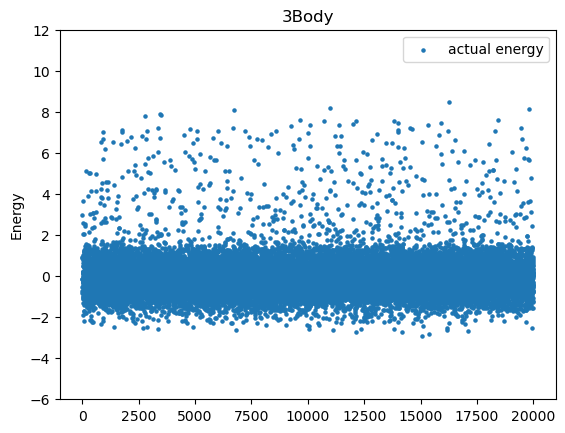

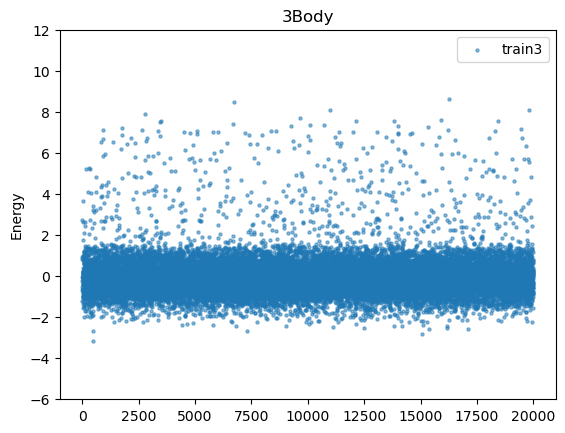

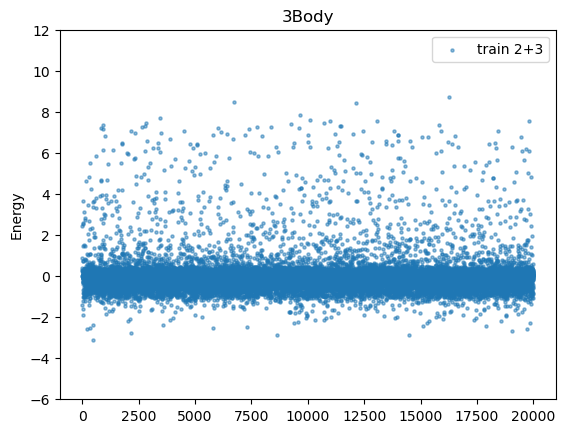

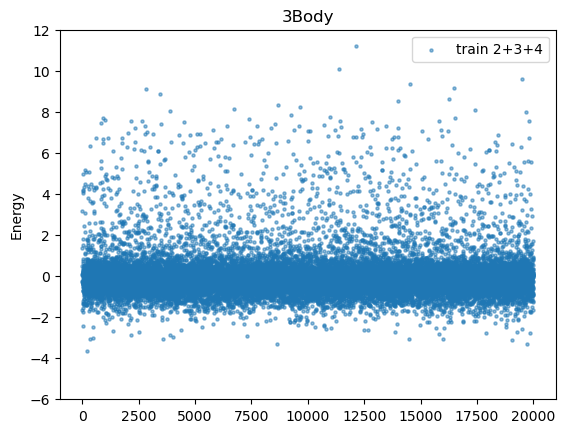

In [58]:
y_test_pred_tr23_te3 
y_test_pred_tr234_te3
y_test_pred_tr3_te3
y_test_234

print(f"train with 3 body, energy from 3 body{stats.describe(y_test_pred_tr3_te3)}")
print(f"train with 2+3 body, energy from 3 body{stats.describe(y_test_pred_tr23_te3)}")
print(f"train with 2+3+4 body, energy from 3 body{stats.describe(y_test_pred_tr234_te3)}")
print(f"actual energy {stats.describe(y_test_234)}")

points_values = np.arange(0,20000,1)
# plt.scatter(points_values, y_test_pred_tr3_te3, s=5, label = "train3", alpha=0.5)
# plt.scatter(points_values, y_test_pred_tr23_te3, s=5, label="train 2+3", alpha=0.5)
# plt.scatter(points_values, y_test_pred_tr234_te3, s=5, label= "train 2+3+4", alpha=0.5)
plt.scatter(points_values, y_test_234, s=5, label = "actual energy")
plt.title("3Body")
plt.ylim(-6,12)
plt.legend()
plt.ylabel("Energy")
plt.show()

points_values = np.arange(0,20000,1)
plt.scatter(points_values, y_test_pred_tr3_te3, s=5, label = "train3", alpha=0.5)
# plt.scatter(points_values, y_test_pred_tr23_te3, s=5, label="train 2+3", alpha=0.5)
# plt.scatter(points_values, y_test_pred_tr234_te3, s=5, label= "train 2+3+4", alpha=0.5)
# plt.scatter(points_values, y_test_234, s=5, label = "actual energy")
plt.title("3Body")
plt.ylim(-6,12)
plt.legend()
plt.ylabel("Energy")
plt.show()

points_values = np.arange(0,20000,1)
# plt.scatter(points_values, y_test_pred_tr3_te3, s=5, label = "train3", alpha=0.5)
plt.scatter(points_values, y_test_pred_tr23_te3, s=5, label="train 2+3", alpha=0.5)
# plt.scatter(points_values, y_test_pred_tr234_te3, s=5, label= "train 2+3+4", alpha=0.5)
# plt.scatter(points_values, y_test_234, s=5, label = "actual energy")
plt.title("3Body")
plt.ylim(-6,12)
plt.legend()
plt.ylabel("Energy")
plt.show()

points_values = np.arange(0,20000,1)
# plt.scatter(points_values, y_test_pred_tr2_te3, s=5, label = "train3", alpha=0.5)
# plt.scatter(points_values, y_test_pred_tr23_te3, s=5, label="train 2+3", alpha=0.5)
plt.scatter(points_values, y_test_pred_tr234_te3, s=5, label= "train 2+3+4", alpha=0.5)
# plt.scatter(points_values, y_test_234, s=5, label = "actual energy")
plt.title("3Body")
plt.ylim(-6,12)
plt.legend()
plt.ylabel("Energy")
plt.show()

train with 3 body, energy from 3 bodyDescribeResult(nobs=20000, minmax=(-3.176969863347898, 12.594378591591214), mean=0.0019705625541382907, variance=0.9951875976396704, skewness=2.6430665068395696, kurtosis=14.940040964654635)
train with 2+3 body, energy from 3 bodyDescribeResult(nobs=20000, minmax=(-3.125971568031379, 12.298544463785445), mean=0.038472594074428455, variance=0.7253101825088327, skewness=4.346243853413304, kurtosis=29.195280976792)
train with 2+3+4 body, energy from 3 bodyDescribeResult(nobs=20000, minmax=(-3.637372137937631, 12.991677635281361), mean=0.022751584155924067, variance=1.2678633657082974, skewness=2.9864089166591645, kurtosis=14.528779216186251)
actual energy DescribeResult(nobs=20000, minmax=(-2.929646128896188, 12.747283130003368), mean=-0.00013950106833275768, variance=1.0255547422093227, skewness=2.5221623289804525, kurtosis=14.14380645146084)


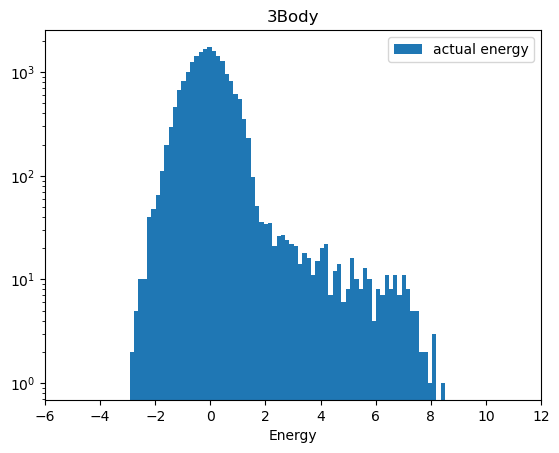

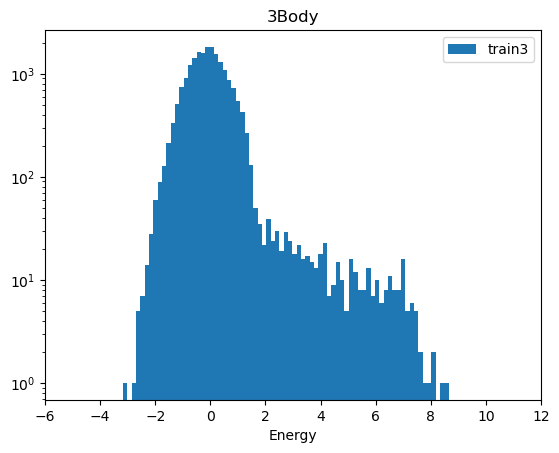

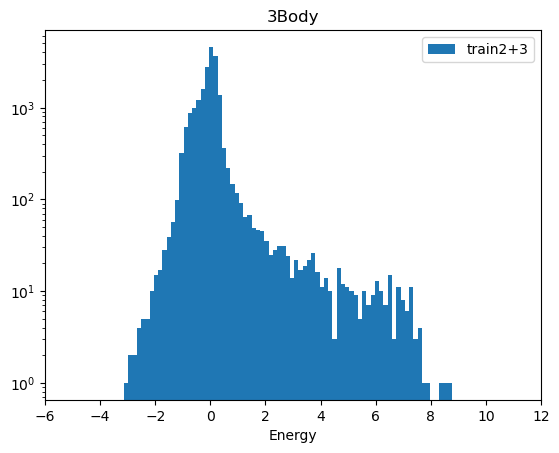

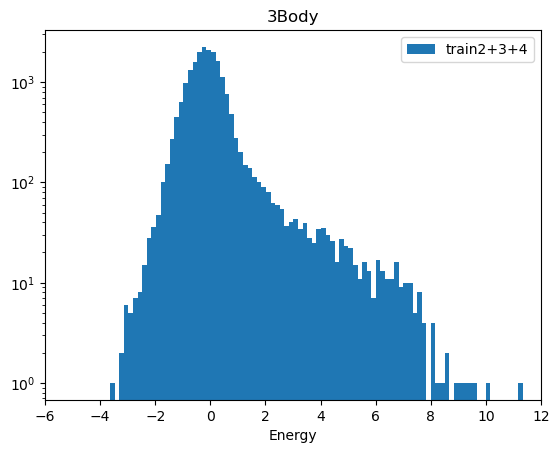

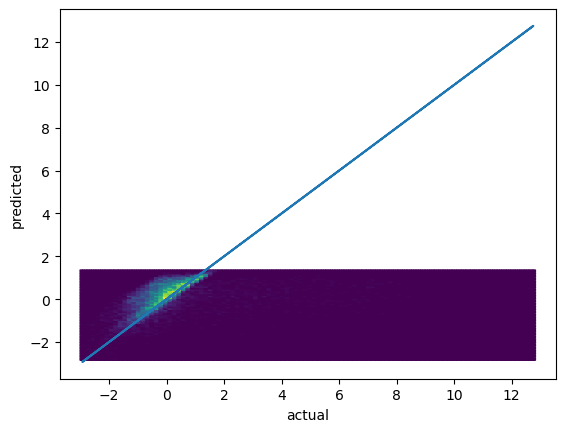

In [82]:
y_test_pred_tr23_te3 
y_test_pred_tr234_te3
y_test_pred_tr3_te3
y_test_234

print(f"train with 3 body, energy from 3 body{stats.describe(y_test_pred_tr3_te3)}")
print(f"train with 2+3 body, energy from 3 body{stats.describe(y_test_pred_tr23_te3)}")
print(f"train with 2+3+4 body, energy from 3 body{stats.describe(y_test_pred_tr234_te3)}")
print(f"actual energy {stats.describe(y_test_234)}")

# plt.hist( y_test_pred_tr3_te3, bins=100, density=True, label = "train3")
# plt.hist( y_test_pred_tr23_te3, bins=100, density=True, label = "train2+3")
# plt.hist( y_test_pred_tr234_te3, bins=100, density=True, label = "train2+3+4")
plt.hist( y_test_234, bins=100, label = "actual energy")
plt.xlim(-6,12)
plt.yscale("log")
plt.title("3Body")
plt.legend()
plt.xlabel("Energy")
plt.show()

plt.hist( y_test_pred_tr3_te3, bins=100, label = "train3")
# plt.hist( y_test_pred_tr23_te3, bins=100, density=True, label = "train2+3")
# plt.hist( y_test_pred_tr234_te3, bins=100, density=True, label = "train2+3+4")
# plt.hist( y_test_234, bins=100, density=True, label = "actual energy")
plt.yscale("log")
plt.xlim(-6,12)
plt.title("3Body")
plt.legend()
plt.xlabel("Energy")
plt.show()

# plt.hist( y_test_pred_tr2_te2, bins=100, density=True, label = "train2")
plt.hist( y_test_pred_tr23_te3, bins=100, label = "train2+3")
# plt.hist( y_test_pred_tr234_te3, bins=100, density=True, label = "train2+3+4")
# plt.hist( y_test_234, bins=100, density=True, label = "actual energy")
plt.yscale("log")
plt.xlim(-6,12)
plt.title("3Body")
plt.legend()
plt.xlabel("Energy")
plt.show()

# plt.hist( y_test_pred_tr2_te2, bins=100, density=True, label = "train2")
# plt.hist( y_test_pred_tr23_te2, bins=100, density=True, label = "train2+3")
plt.hist( y_test_pred_tr234_te3, bins=100, label = "train2+3+4")
# plt.hist( y_test_234, bins=100, density=True, label = "actual energy")
plt.yscale("log")
plt.xlim(-6,12)
plt.title("3Body")
plt.legend()
plt.xlabel("Energy")
plt.show()

plt.hexbin(y_test_234, y_test_pred_tr23_te2)
plt.plot(y_test_234, y_test_234)
plt.xlabel("actual")
plt.ylabel("predicted")
plt.show()

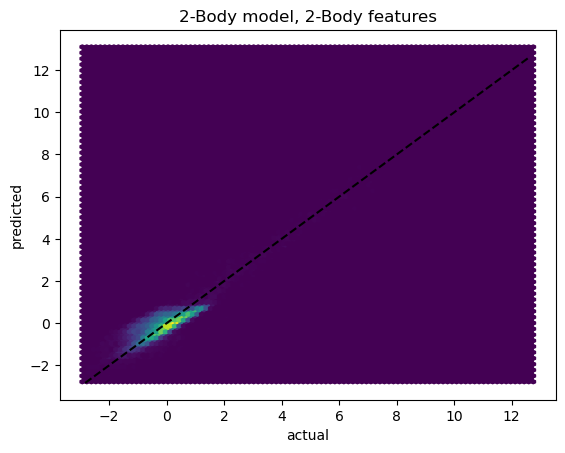

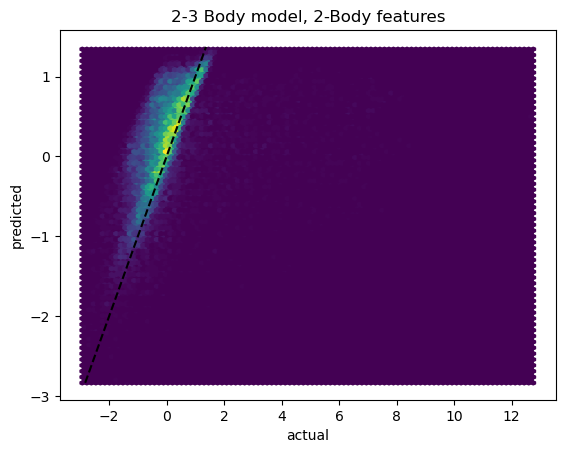

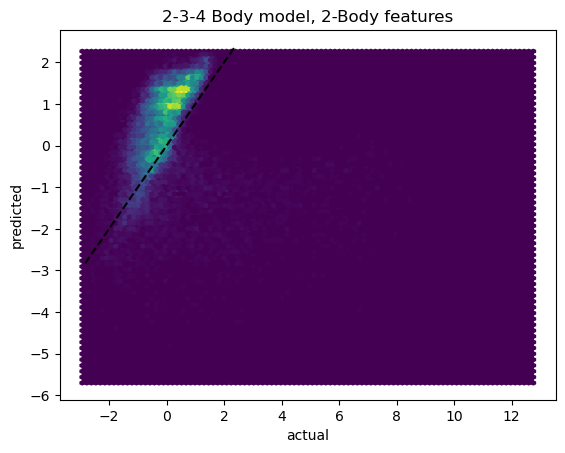

In [115]:
x= np.arange(-2.83,12.7, 0.2)
plt.hexbin(y_test_234, y_test_pred_tr2_te2)
plt.plot(x,x, color="black", linestyle="dashed")
plt.xlabel("actual")
plt.title("2-Body model, 2-Body features")
plt.ylabel("predicted")
plt.show()

x= np.arange(-2.83,1.53, 0.2)
plt.hexbin(y_test_234, y_test_pred_tr23_te2)
plt.plot(x,x, color="black", linestyle="dashed")
plt.xlabel("actual")
plt.title("2-3 Body model, 2-Body features")
plt.ylabel("predicted")
plt.show()

x= np.arange(-2.83,2.45, 0.2)
plt.hexbin(y_test_234, y_test_pred_tr234_te2)
plt.plot(x,x, color="black", linestyle="dashed")
plt.xlabel("actual")
plt.title("2-3-4 Body model, 2-Body features")
plt.ylabel("predicted")
plt.show()

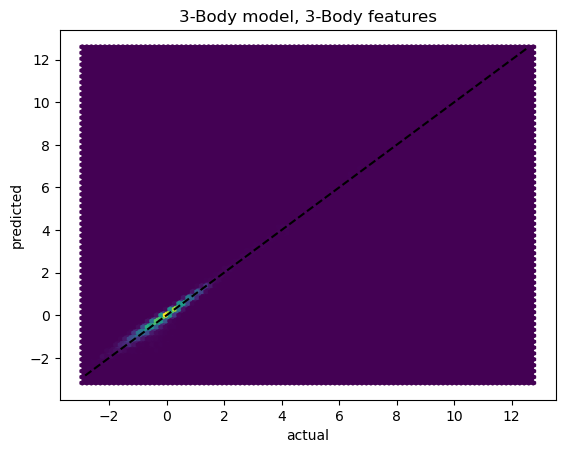

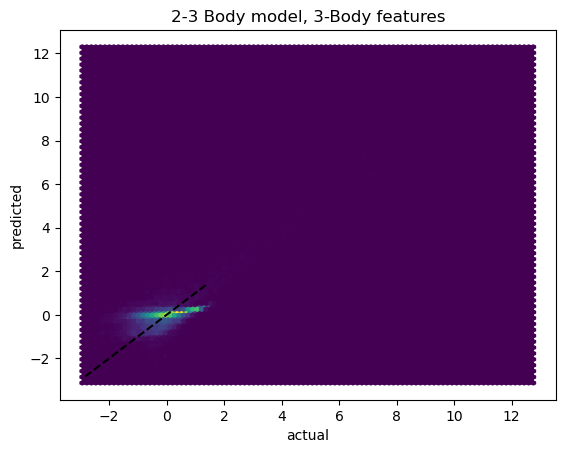

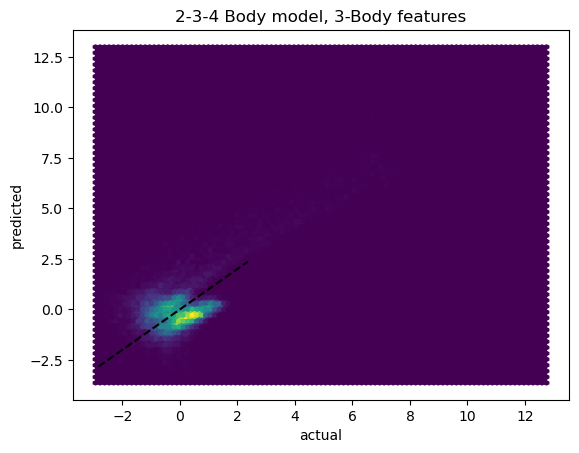

In [116]:
x= np.arange(-2.83,12.7, 0.2)
plt.hexbin(y_test_234, y_test_pred_tr3_te3)
plt.plot(x,x, color="black", linestyle="dashed")
plt.xlabel("actual")
plt.title("3-Body model, 3-Body features")
plt.ylabel("predicted")
plt.show()

x= np.arange(-2.83,1.53, 0.2)
plt.hexbin(y_test_234, y_test_pred_tr23_te3)
plt.plot(x,x, color="black", linestyle="dashed")
plt.xlabel("actual")
plt.title("2-3 Body model, 3-Body features")
plt.ylabel("predicted")
plt.show()

x= np.arange(-2.83,2.45, 0.2)
plt.hexbin(y_test_234, y_test_pred_tr234_te3)
plt.plot(x,x, color="black", linestyle="dashed")
plt.xlabel("actual")
plt.title("2-3-4 Body model, 3-Body features")
plt.ylabel("predicted")
plt.show()